In [80]:
import numpy as np

# 加载训练集数据
X_train = np.load('../data_set/X_train.npy')
Y_train = np.load('../data_set/Y_train.npy')

# 输出初识数据集的大小
X_train.shape, Y_train.shape

((1000, 111), (1000, 11))

### 统计不同区间内的缺失率

In [81]:
# 统计特征、样本在不同区间内的缺失率
def missing_ratio(X):
    # 计算每个特征、样本的缺失率
    feature_missing_ratio = np.mean(np.isnan(X), axis=0)
    sample_missing_ratio = np.mean(np.isnan(X), axis=1)

    # 定义缺失率的区间
    bins = np.arange(0, 1.1, 0.1)  # [0, 0.1, 0.2, ..., 1.0]

    # 计算在每个区间的特征、样本数量
    feature_hist, _ = np.histogram(feature_missing_ratio, bins=bins)
    sample_hist, _ = np.histogram(sample_missing_ratio, bins=bins)

    return feature_hist, sample_hist


# 输出特征、样本缺失率分布情况
def print_missing_ratio(X):
    feature_hist, sample_hist = missing_ratio(X)

    print("特征缺失率分布:")
    for i in range(len(feature_hist)):
        print("[{:.0%} - {:.0%}]: {}".format(i * 0.1, (i + 1) * 0.1, feature_hist[i]))

    print("\n样本缺失率分布:")
    for i in range(len(sample_hist)):
        print("[{:.0%} - {:.0%}]: {}".format(i * 0.1, (i + 1) * 0.1, sample_hist[i]))

In [82]:
# 输出原始数据集的缺失率分布
print_missing_ratio(X_train)

特征缺失率分布:
[0% - 10%]: 94
[10% - 20%]: 6
[20% - 30%]: 4
[30% - 40%]: 3
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 2
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 2

样本缺失率分布:
[0% - 10%]: 784
[10% - 20%]: 129
[20% - 30%]: 46
[30% - 40%]: 38
[40% - 50%]: 2
[50% - 60%]: 1
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0


### 删除高缺失率

In [83]:
# 删除高缺失率的特征和样本
def remove_high_missing(X, Y, feature_threshold, sample_threshold):
    # 计算每个特征、样本的缺失率
    feature_missing_ratio = np.mean(np.isnan(X), axis=0)
    sample_missing_ratio = np.mean(np.isnan(X), axis=1)

    # 删除高缺失率的特征
    feature_idx = np.where(feature_missing_ratio > feature_threshold)[0]
    X = np.delete(X, feature_idx, axis=1)

    # 删除高缺失率的样本
    sample_idx = np.where(sample_missing_ratio > sample_threshold)[0]
    X = np.delete(X, sample_idx, axis=0)
    Y = np.delete(Y, sample_idx, axis=0)

    return X, Y

In [84]:
# 删除高缺失率的特征和样本
X_remove_high_missing, Y_remove_high_missing = remove_high_missing(X_train, Y_train, 0.6, 0.2)

# 输出删除后的数据集大小
X_remove_high_missing.shape, Y_remove_high_missing.shape

((913, 107), (913, 11))

### 删除一元特征

In [85]:
import numpy as np


def remove_unary_features(X):
    # 初始化一个空的索引列表
    unary_feature_indices = []

    # 遍历每个特征
    for i in range(X.shape[1]):
        # 获取特征的唯一值
        unique_values = np.unique(X[:, i])

        # 如果唯一值的数量小于等于1，那么这是一个一元特征
        if len(unique_values) <= 1:
            unary_feature_indices.append(i)

    # 删除一元特征
    X = np.delete(X, unary_feature_indices, axis=1)

    return X

In [86]:
# 删除一元特征
X_remove_unary = remove_unary_features(X_remove_high_missing)

# 输出删除后的数据集大小
X_remove_unary.shape

(913, 102)

In [87]:
# 保存删除后的数据集
np.save('../data_set/preprocessed/01_remove/X_remove.npy', X_remove_unary)
np.save('../data_set/preprocessed/01_remove/Y_remove.npy', Y_remove_high_missing)

In [88]:
# 输出删除后的数据集的缺失率分布
print_missing_ratio(X_remove_unary)

特征缺失率分布:
[0% - 10%]: 89
[10% - 20%]: 10
[20% - 30%]: 0
[30% - 40%]: 3
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0

样本缺失率分布:
[0% - 10%]: 864
[10% - 20%]: 49
[20% - 30%]: 0
[30% - 40%]: 0
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0


### 特征类型分类
对特征进行分类
- 连续性特征: 唯一值数量大于一定阈值的特征
    - 整型: 所有值都是整数
    - 浮点型: 存在小数
- 离散性特征: 唯一值数量小于一定阈值的特征

In [89]:
def classify_features(X, threshold_ratio=0.05):
    """
    将数据集的特征分为离散型、连续型、连续整型和连续浮点型。

    Parameters:
    - X: 要对特征进行分类的数据集。
    - threshold_ratio: 用于确定特征是离散还是连续的阈值比率。

    Returns:
    - discrete_feature_indices: 离散特征的索引。
    - continuous_feature_indices: 连续特征的索引。
    - binary_feature_indices: 二元特征的索引。
    - multi_feature_indices: 多元特征的索引。
    - continuous_integer_indices: 连续整型特征的索引。
    - continuous_float_indices: 连续浮点型特征的索引。
    """
    # 计算每个特征的唯一值数量
    unique_counts = np.apply_along_axis(lambda col: len(np.unique(col[~np.isnan(col)])), 0, X)

    # 根据阈值比率划分离散和连续特征
    discrete_feature_indices = np.where((unique_counts / X.shape[0]) < threshold_ratio)[0]
    continuous_feature_indices = np.where((unique_counts / X.shape[0]) >= threshold_ratio)[0]

    # 初始化列表，以保存连续整数和浮点特征的索引
    continuous_integer_indices = []
    continuous_float_indices = []

    # 将连续特征分为整数和浮点两种
    for index in continuous_feature_indices:
        if np.all(np.mod(X[:, index][~np.isnan(X[:, index])], 1) == 0):
            continuous_integer_indices.append(index)
        else:
            continuous_float_indices.append(index)

    # 初始化列表，以保存二元和多元特征的索引
    binary_feature_indices = []
    multi_feature_indices = []

    # 将离散特征分为二元和多元两种
    for index in discrete_feature_indices:
        if len(np.unique(X[:, index][~np.isnan(X[:, index])])) == 2:
            binary_feature_indices.append(index)
        else:
            multi_feature_indices.append(index)

    return discrete_feature_indices, continuous_feature_indices, binary_feature_indices, multi_feature_indices, continuous_integer_indices, continuous_float_indices


def print_feature_classification(X):
    """
    输出特征的分类情况。

    Parameters:
    - X: 要输出特征分类的数据集。
    """
    discrete_feature_indices, continuous_feature_indices, binary_feature_indices, multi_feature_indices, continuous_integer_indices, continuous_float_indices = classify_features(
        X)

    print("离散特征数量: {}".format(len(discrete_feature_indices)))
    print("连续特征数量: {}".format(len(continuous_feature_indices)))
    print("二元特征数量: {}".format(len(binary_feature_indices)))
    print("多元特征数量: {}".format(len(multi_feature_indices)))
    print("连续整型特征数量: {}".format(len(continuous_integer_indices)))
    print("连续浮点型特征数量: {}".format(len(continuous_float_indices)))

    print("\n离散特征索引: {}".format(discrete_feature_indices))
    print("连续特征索引: {}".format(continuous_feature_indices))
    print("二元特征索引: {}".format(binary_feature_indices))
    print("多元特征索引: {}".format(multi_feature_indices))
    print("连续整型特征索引: {}".format(continuous_integer_indices))
    print("连续浮点型特征索引: {}".format(continuous_float_indices))

In [90]:
# 输出特征的分类情况
print_feature_classification(X_remove_unary)

离散特征数量: 93
连续特征数量: 9
二元特征数量: 61
多元特征数量: 32
连续整型特征数量: 3
连续浮点型特征数量: 6

离散特征索引: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  76  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101]
连续特征索引: [ 0 29 30 75 77 78 79 80 81]
二元特征索引: [7, 10, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 32, 33, 34, 35, 36, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 85, 86, 87, 88, 96, 97, 98, 99, 100, 101]
多元特征索引: [1, 2, 3, 4, 5, 6, 8, 9, 11, 15, 16, 27, 31, 37, 38, 39, 40, 45, 69, 72, 74, 76, 82, 83, 84, 89, 90, 91, 92, 93, 94, 95]
连续整型特征索引: [0, 29, 30]
连续浮点型特征索引: [75, 77, 78, 79, 80, 81]


### 确定缺失值填充策略
1. 朴素填充:
- 连续整型特征: 用中位数填充
- 连续浮点型特征: 用平均数填充
- 离散特征: 用众数填充
2. KNN填充
3. 回归填充

### 朴素填充

In [98]:
from sklearn.impute import SimpleImputer


def naive_fill(X, discrete_indices, continuous_int_indices, continuous_float_indices):
    imputer_mode = SimpleImputer(strategy='most_frequent')
    imputer_median = SimpleImputer(strategy='median')
    imputer_mean = SimpleImputer(strategy='mean')

    if len(discrete_indices) > 0:  # 检查是否有离散型索引
        X[:, discrete_indices] = imputer_mode.fit_transform(X[:, discrete_indices])
    if len(continuous_int_indices) > 0:  # 检查是否有连续整数型索引
        X[:, continuous_int_indices] = imputer_median.fit_transform(X[:, continuous_int_indices])
    if len(continuous_float_indices) > 0:  # 检查是否有连续浮点型索引
        X[:, continuous_float_indices] = imputer_mean.fit_transform(X[:, continuous_float_indices])

    return X


### KNN填充

In [92]:
from sklearn.impute import KNNImputer


def knn_fill(X, n_neighbors=5):
    """
    Fills missing values using K-Nearest Neighbors.
    
    Parameters:
    - X: The dataset with missing values.
    - n_neighbors: Number of neighboring samples to use for imputation.
    """
    imputer = KNNImputer(n_neighbors=n_neighbors)
    return imputer.fit_transform(X)


### 回归填充
利用线性模型进行回归填充。这个函数将会更复杂，因为它需要根据其它特征来预测缺失的特征值。

In [94]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression


def regression_fill(X):
    """
    Fills missing values using regression imputation with a Linear Regression model.
    """
    imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=0)
    return imputer.fit_transform(X)


### 执行缺失值填充
分别使用朴素填充、KNN填充和回归填充对数据集进行填充，输出填充后的数据集的缺失率分布，并保存填充后的数据集。

In [99]:
# 使用朴素填充填充数据
discrete_feature_indices, continuous_feature_indices, binary_feature_indices, multi_feature_indices, continuous_integer_indices, continuous_float_indices = classify_features(
    X_remove_unary)

X_filled_naive = naive_fill(X_remove_unary, discrete_feature_indices, continuous_integer_indices,
                            continuous_float_indices)

# 输出填充后的数据集的缺失率分布
print_missing_ratio(X_filled_naive)

# 保存填充后的数据集
np.save('../data_set/preprocessed/02_filled/X_filled_naive.npy', X_filled_naive)

特征缺失率分布:
[0% - 10%]: 102
[10% - 20%]: 0
[20% - 30%]: 0
[30% - 40%]: 0
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0

样本缺失率分布:
[0% - 10%]: 913
[10% - 20%]: 0
[20% - 30%]: 0
[30% - 40%]: 0
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0


In [100]:
# 使用KNN填充填充数据
X_filled_knn = knn_fill(X_remove_unary)

# 输出填充后的数据集的缺失率分布
print_missing_ratio(X_filled_knn)

# 保存填充后的数据集
np.save('../data_set/preprocessed/02_filled/X_filled_knn.npy', X_filled_knn)

特征缺失率分布:
[0% - 10%]: 102
[10% - 20%]: 0
[20% - 30%]: 0
[30% - 40%]: 0
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0

样本缺失率分布:
[0% - 10%]: 913
[10% - 20%]: 0
[20% - 30%]: 0
[30% - 40%]: 0
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0


In [101]:
# 使用回归填充填充数据
X_filled_regression = regression_fill(X_remove_unary)

# 输出填充后的数据集的缺失率分布
print_missing_ratio(X_filled_regression)

# 保存填充后的数据集
np.save('../data_set/preprocessed/02_filled/X_filled_regression.npy', X_filled_regression)

特征缺失率分布:
[0% - 10%]: 102
[10% - 20%]: 0
[20% - 30%]: 0
[30% - 40%]: 0
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0

样本缺失率分布:
[0% - 10%]: 913
[10% - 20%]: 0
[20% - 30%]: 0
[30% - 40%]: 0
[40% - 50%]: 0
[50% - 60%]: 0
[60% - 70%]: 0
[70% - 80%]: 0
[80% - 90%]: 0
[90% - 100%]: 0


### 离群值处理

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns


def process_outliers(X):
    """
    Processes outliers for specified continuous features and reports details.
    
    Parameters:
    - X: The dataset to process outliers for.
    
    Returns:
    - X_processed: The dataset with outliers processed.
    - reports: A dictionary containing reports on processed features.
    """
    X = X.copy()
    _, _, _, _, continuous_integer_indices, continuous_float_indices = classify_features(X)
    reports = {}
    continuous_feature_indices = continuous_integer_indices + continuous_float_indices

    for feature_index in continuous_feature_indices:
        feature_data = X[:, feature_index]
        q1, q3 = np.percentile(feature_data[~np.isnan(feature_data)], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outlier_indices = np.where((feature_data < lower_bound) | (feature_data > upper_bound))[0]

        # Cap the outliers
        X[:, feature_index] = np.where(feature_data < lower_bound, lower_bound,
                                       np.where(feature_data > upper_bound, upper_bound, feature_data))

        reports[feature_index] = {
            'outlier_count': len(outlier_indices),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return X, reports


def visualize_outliers(feature_data, feature_data_capped, feature_index):
    """
    Visualizes outliers before and after capping for a given feature.
    
    Parameters:
    - feature_data: Original feature data.
    - feature_data_capped: Feature data after capping outliers.
    - feature_index: Index of the feature being processed.
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=feature_data)
    plt.title(f'Before Capping - Feature {feature_index}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=feature_data_capped)
    plt.title(f'After Capping - Feature {feature_index}')
    plt.show()


def process_and_visualize_outliers(X):
    """
    Processes and visualizes outliers for specified continuous features.
    
    Parameters:
    - X: The dataset to process and visualize outliers for.
    
    Returns:
    - X_processed: The dataset with outliers processed.
    """
    # Process outliers and get reports
    X_processed, reports = process_outliers(X)

    # Iterate over each feature index and its report from the process_outliers function
    for feature_index, report in reports.items():
        feature_data = X[:, feature_index]  # Original feature data before processing
        feature_data_capped = X_processed[:, feature_index]  # Feature data after capping outliers

        # Visualize outliers before and after capping
        visualize_outliers(feature_data, feature_data_capped, feature_index)

    return X_processed


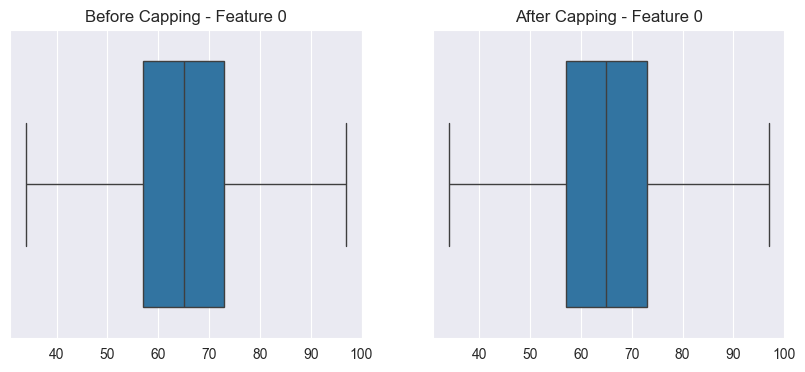

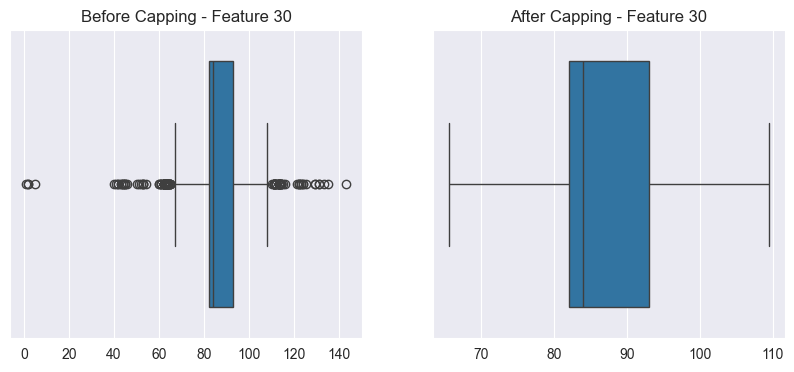

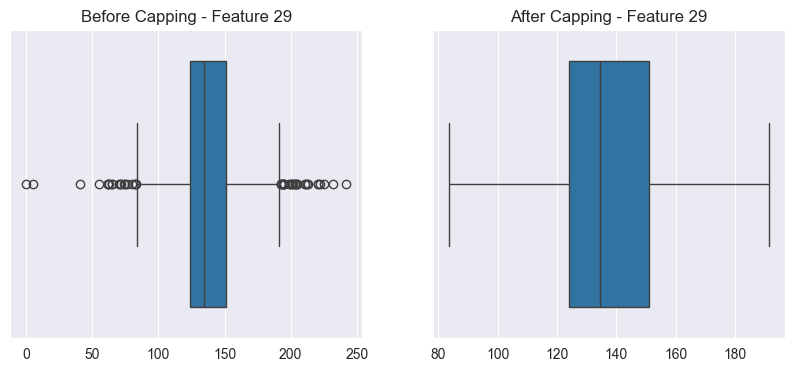

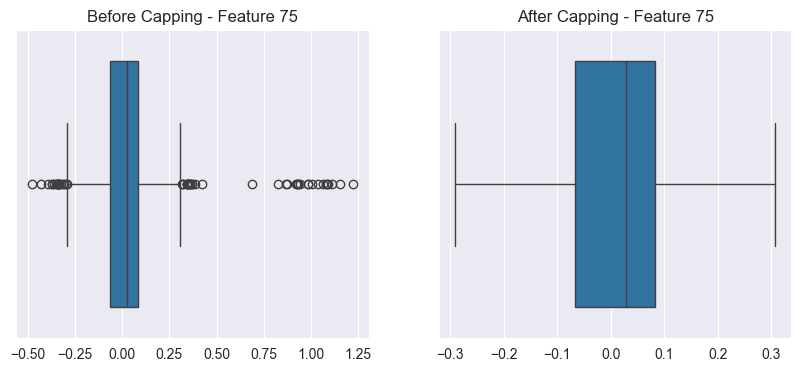

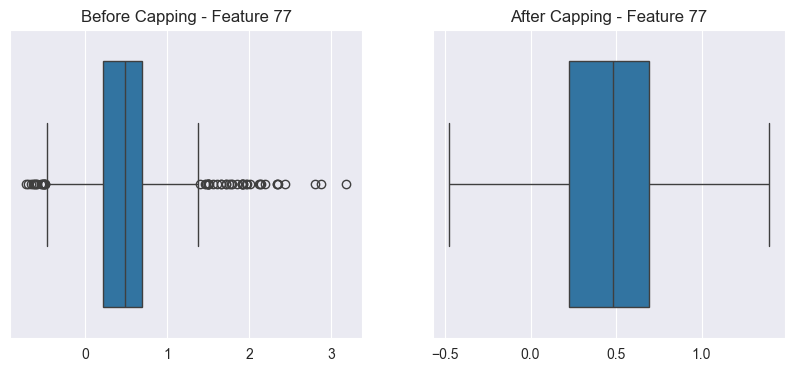

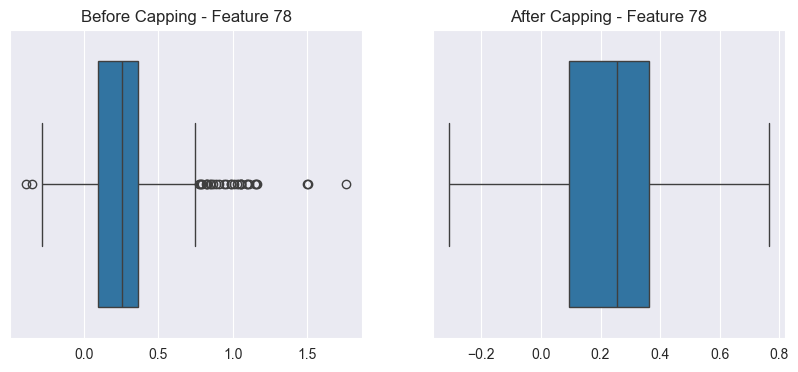

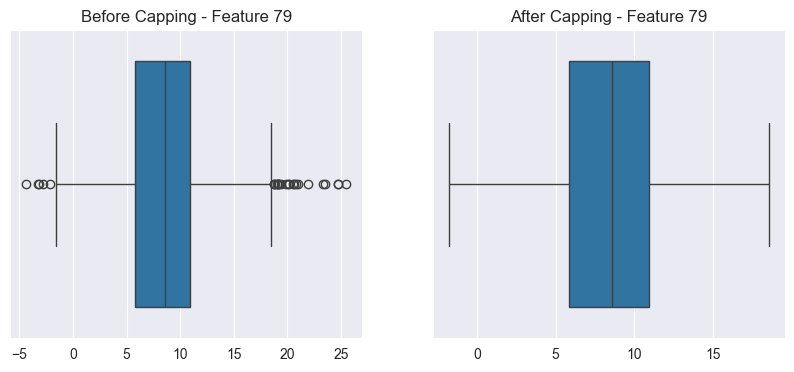

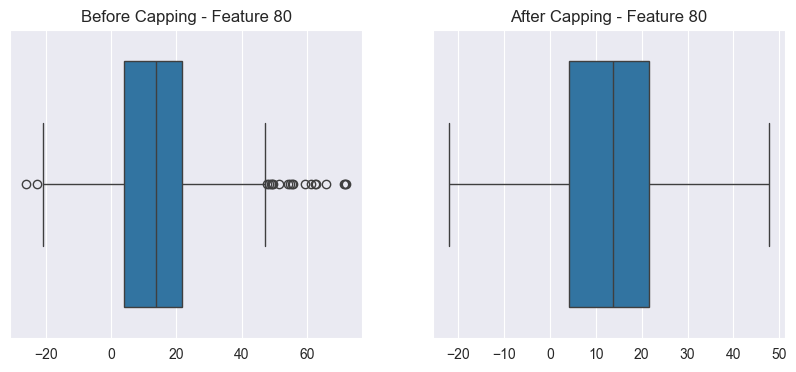

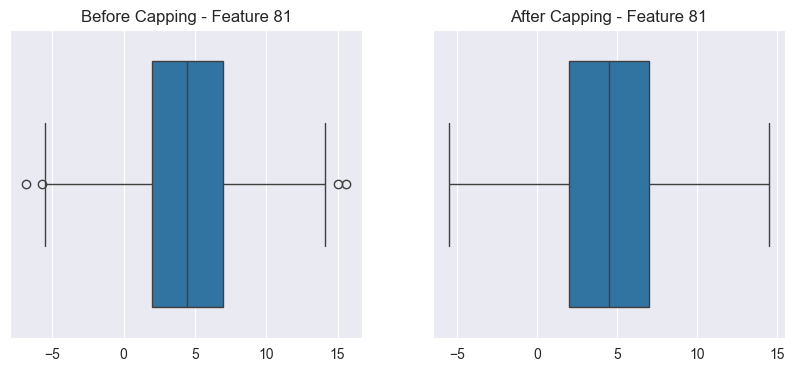

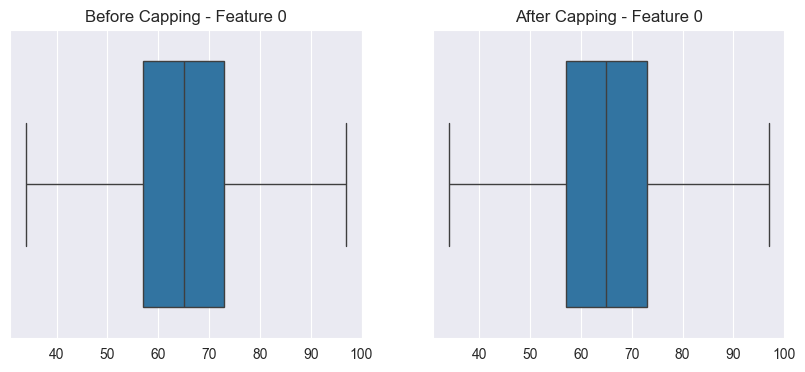

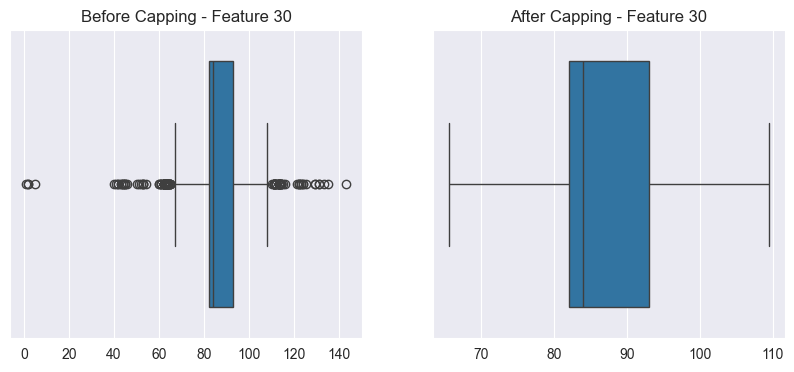

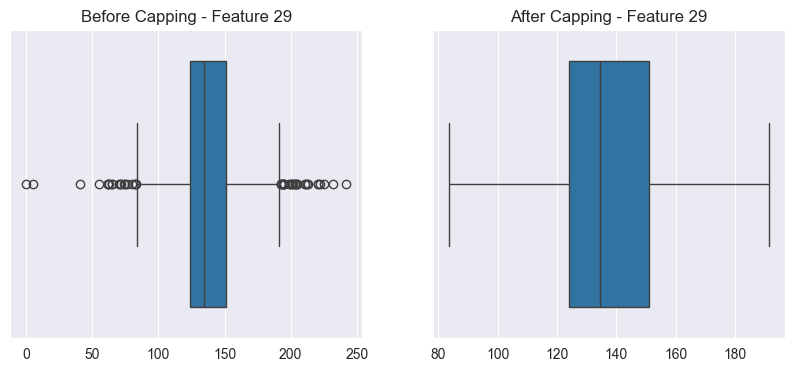

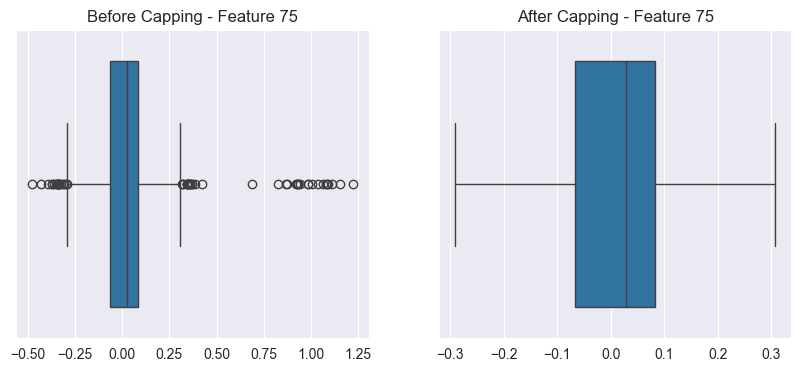

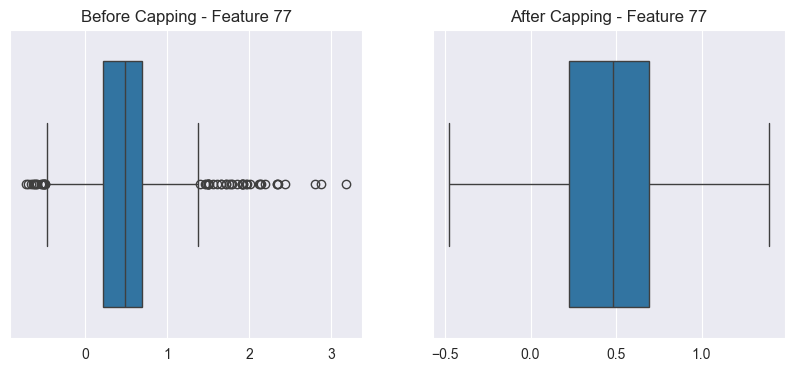

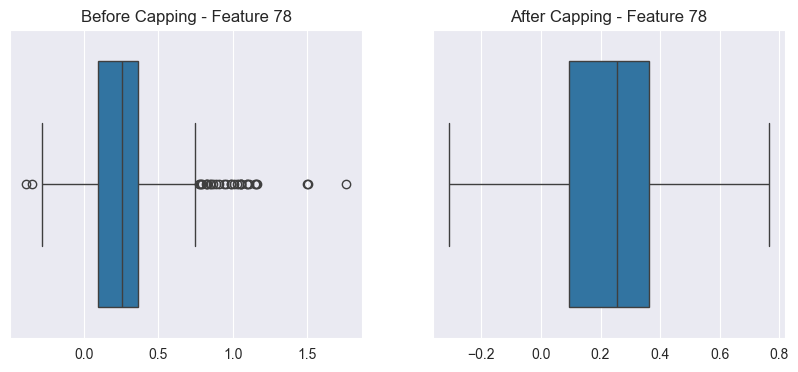

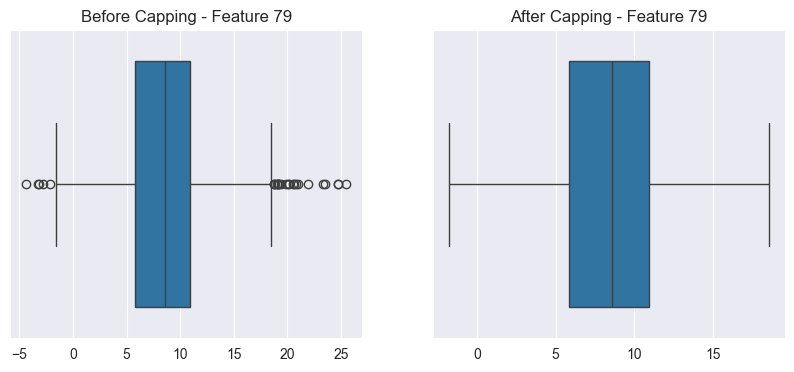

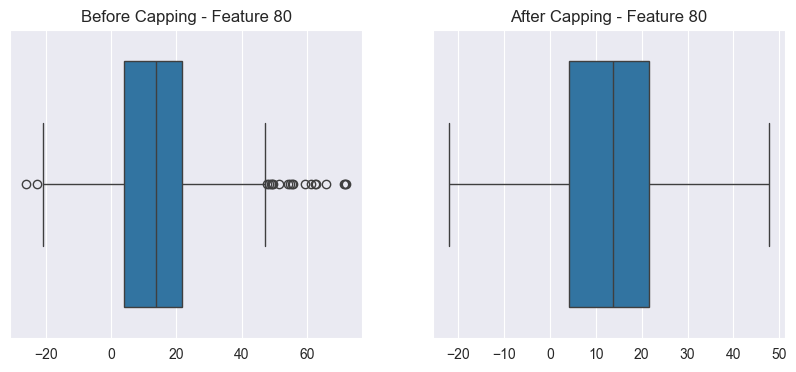

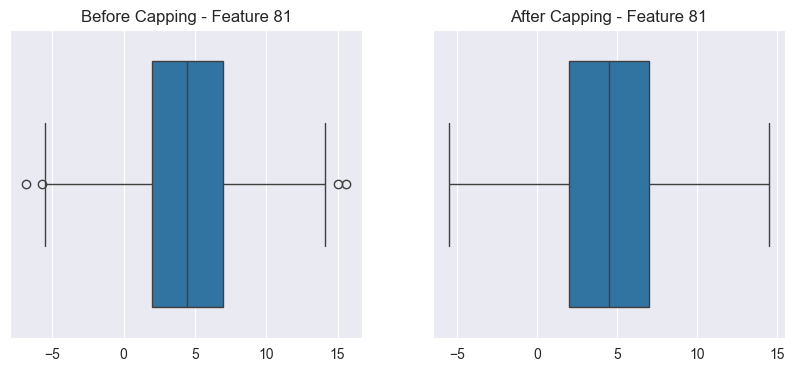

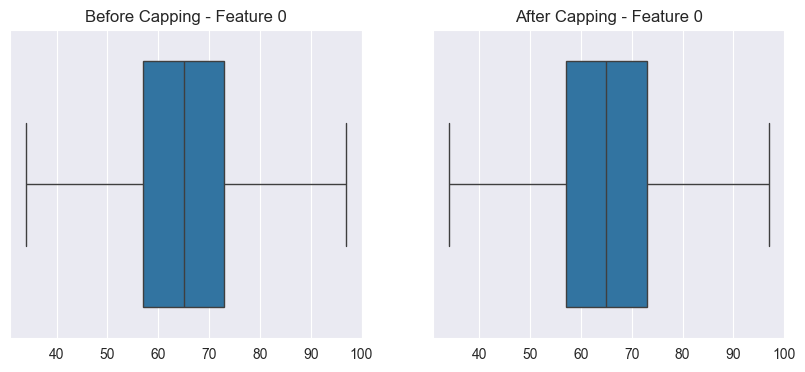

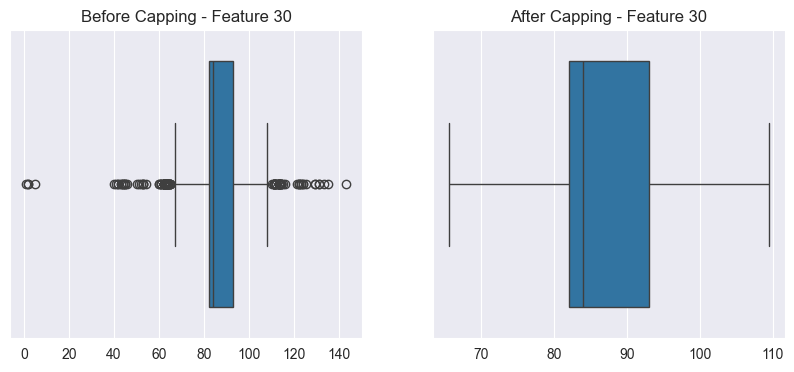

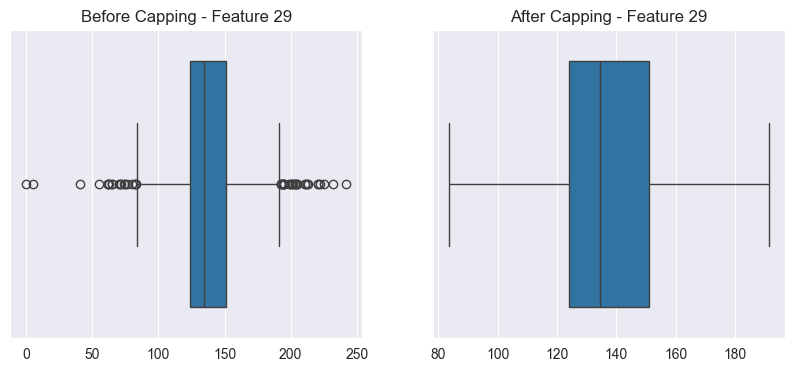

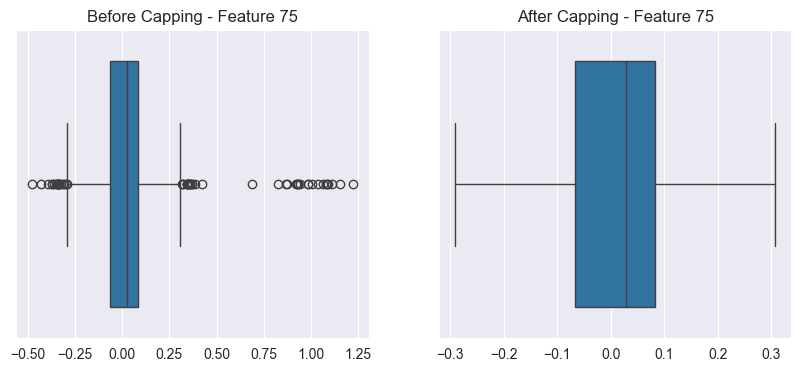

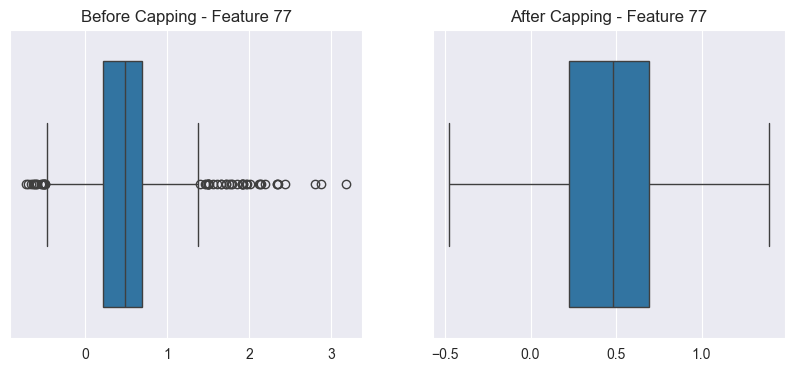

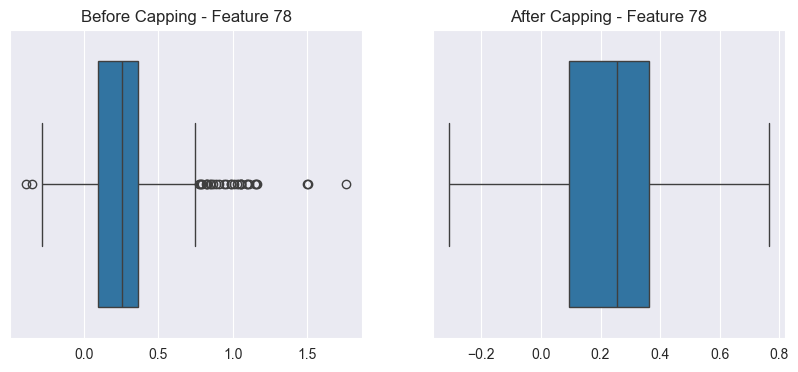

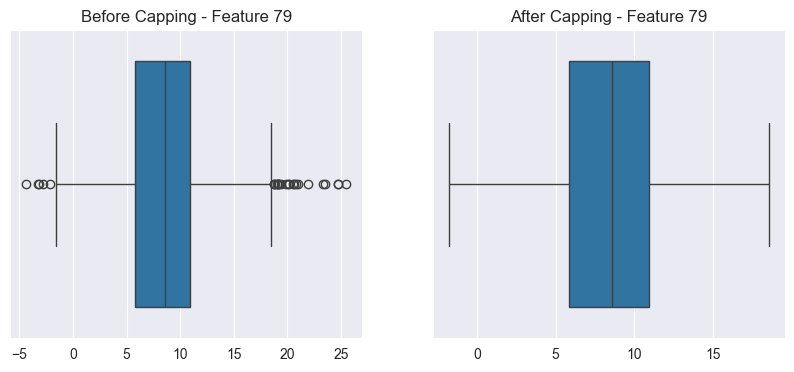

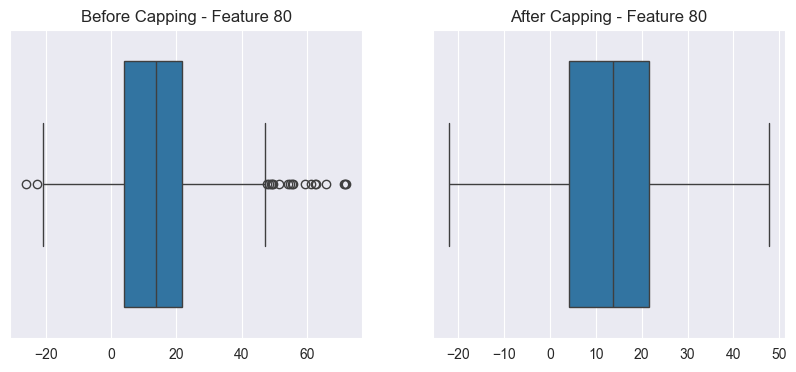

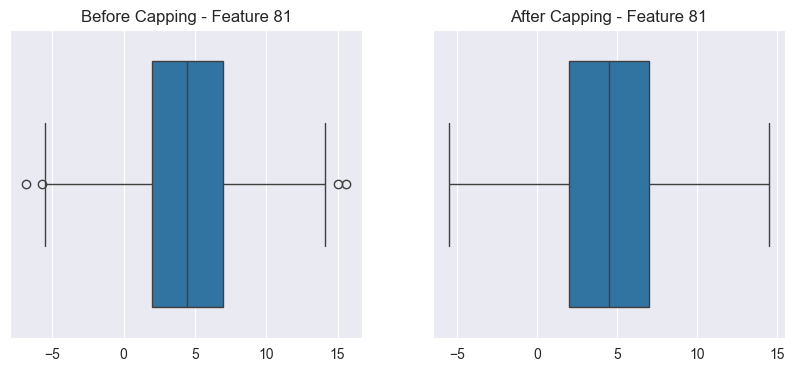

In [109]:
# 处理离群值
X_processed_outliers_naive = process_and_visualize_outliers(X_filled_naive)[0]
X_processed_outliers_knn = process_and_visualize_outliers(X_filled_knn)[0]
X_processed_outliers_regression = process_and_visualize_outliers(X_filled_regression)[0]

# 保存处理后的数据集
np.save('../data_set/preprocessed/03_outliers/X_outliers_naive.npy', X_processed_outliers_naive)
np.save('../data_set/preprocessed/03_outliers/X_outliers_knn.npy', X_processed_outliers_knn)
np.save('../data_set/preprocessed/03_outliers/X_outliers_regression.npy', X_processed_outliers_regression)
